In [1]:
import os
import json
import sys
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


project_root = os.path.abspath(os.path.join(os.getcwd(), "../../.."))
sys.path.insert(0, project_root)

# Load modules 
from src.models.naive_cell import NaivePerCellModel
from src.models.poisson_cell import PoissonPerCellModel
from src.utils.data_partition import temporal_split
from src.evaluation.temporal_evaluation import (
                                                    evaluate_temporal_rmse_mae,
                                                    evaluate_temporal_spatial_metrics,
                                                    evaluate_spatial_metrics_over_coverages
                                                )

# Load global config 
config_path = os.path.join("..", "config.json")
with open(config_path, 'r') as f:
    config = json.load(f)

# Define hotspot method from config
hotspot_percentage = config["evaluation"]["hotspot_percentage"]
hotspot_method = config["evaluation"].get("hotspot_definition", "by_cells")  # default

# Dynamically select hotspot definition method
if hotspot_method == "by_crimes":
    from src.utils.spatial_processing import define_hotspot_by_crimes as define_hotspot
elif hotspot_method == "by_cells":
    from src.utils.spatial_processing import define_hotspot_by_cells as define_hotspot
else:
    raise ValueError(f"Unknown hotspot_definition method: {hotspot_method}") 



rows = config["data_generation"]["rows"]
cols = config["data_generation"]["cols"]
grid_size = (rows, cols)
partition_config = config["data_partition"]
days_per_month = 30
train_days = partition_config["train_months"] * days_per_month
calibration_days = partition_config["calibration_months"] * days_per_month
test_days = partition_config["test_months"] * days_per_month


In [ ]:
# Load data
df = pd.read_csv("../data/examples/poisson_example_40x40.csv")

# Partition data
partition = config["data_partition"]
train_days = partition["train_months"] * 30
calib_days = partition["calibration_months"] * 30
test_days = partition["test_months"] * 30

df_train, df_calib, df_test = temporal_split(df, train_days, train_days + calib_days, train_days + calib_days + test_days)

# Features
features = ["timestep", "row", "col"]
target = "count"

X_train, y_train = df_train[features], df_train[target]
X_test, y_test = df_test[features], df_test[target]

# Train cell-based models
naive_model = NaivePerCellModel()
naive_model.fit(X_train, y_train)

poisson_cell_model = PoissonPerCellModel(use_timestep=True) ## false
poisson_cell_model.fit(X_train, y_train)

# Save models
os.makedirs("../results/models", exist_ok=True)
joblib.dump(naive_model, "../results/models/naive_cell_model.pkl")
joblib.dump(poisson_cell_model, "../results/models/poisson_cell_model.pkl")

# Predict
naive_pred = naive_model.predict(X_test)
poisson_pred = poisson_cell_model.predict(X_test)

# Temporal numeric evaluation
print("\n🔹 Temporal numeric evaluation (per timestep):\n")
for name, pred in zip(["NaiveCell", "PoissonPerCell"], [naive_pred, poisson_pred]):
    scores = evaluate_temporal_rmse_mae(X_test, y_test, pred)
    print(f"{name} - RMSE: {scores['rmse_mean']:.3f} ± {scores['rmse_std']:.3f} | MAE: {scores['mae_mean']:.3f} ± {scores['mae_std']:.3f}")

# Temporal spatial evaluation
print("\n🔹 Temporal spatial metrics (per timestep):\n")
for name, pred in zip(["NaiveCell", "PoissonPerCell"], [naive_pred, poisson_pred]):
    spatial_scores = evaluate_temporal_spatial_metrics(X_test, y_test, pred, grid_size, hotspot_percentage)
    print(f"{name}:")
    print(f"  PAI:     {spatial_scores['pai_mean']:.3f} ± {spatial_scores['pai_std']:.3f}")
    print(f"  PEI:     {spatial_scores['pei_mean']:.3f} ± {spatial_scores['pei_std']:.3f}")
    print(f"  PEI*:    {spatial_scores['pei_star_mean']:.3f} ± {spatial_scores['pei_star_std']:.3f}\n")

# 🔄 Evaluate over multiple coverages
coverages = np.linspace(0.01, 0.5, 10)
curves = {}
for name, pred in zip(["NaiveCell", "PoissonPerCell"], [naive_pred, poisson_pred]):
    curves[name] = evaluate_spatial_metrics_over_coverages(X_test, y_test, pred, grid_size, coverages)




🔹 Temporal numeric evaluation (per timestep):

NaiveCell - RMSE: 1.741 ± 0.043 | MAE: 1.302 ± 0.023
PoissonPerCell - RMSE: 1.895 ± 0.074 | MAE: 1.429 ± 0.049

🔹 Temporal spatial metrics (per timestep):

NaiveCell:
  PAI:     4.299 ± 0.298
  PEI:     0.724 ± 0.035
  PEI*:    0.773 ± 0.035

PoissonPerCell:
  PAI:     4.332 ± 0.360
  PEI:     0.730 ± 0.046
  PEI*:    0.766 ± 0.047



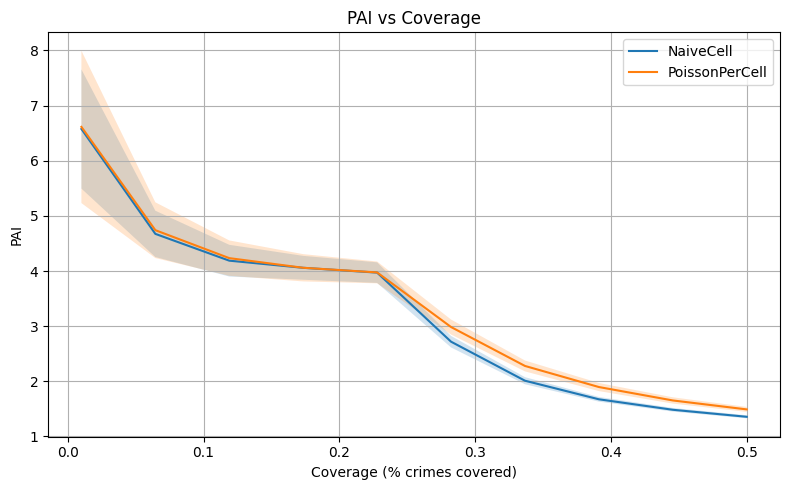

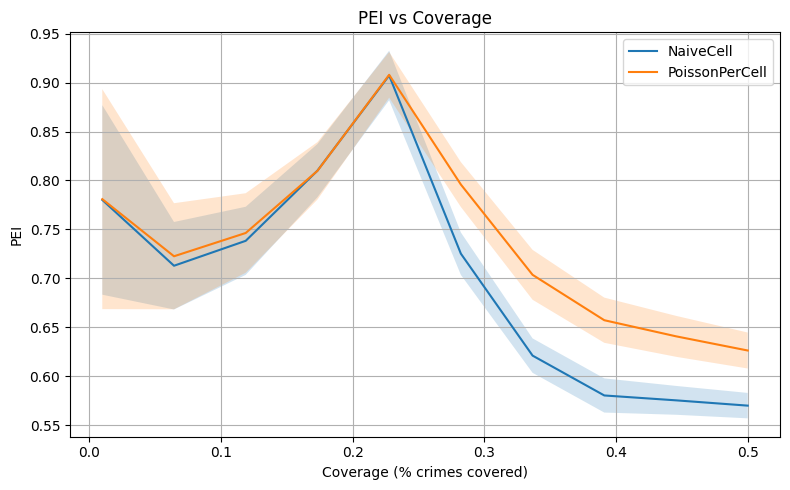

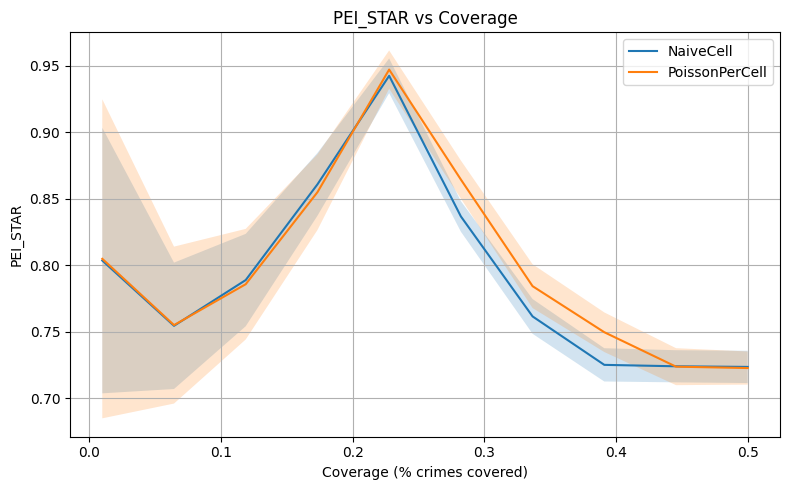

In [3]:
# 📈 Plot curves with seaborn
metrics = ["pai", "pei", "pei_star"]
for metric in metrics:
    plt.figure(figsize=(8, 5))
    for model in curves:
        df = curves[model]
        mean_col = f"{metric}_mean"
        std_col = f"{metric}_std"
        
        sns.lineplot(x="coverage", y=mean_col, data=df, label=model)
        plt.fill_between(df["coverage"], df[mean_col] - df[std_col], df[mean_col] + df[std_col], alpha=0.2)

    plt.xlabel("Coverage (% crimes covered)")
    plt.ylabel(metric.upper())
    plt.title(f"{metric.upper()} vs Coverage")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()